In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.fft
from scipy.special import factorial
import math
# import csv
from matplotlib import rc, rcParams

def fitlin(x, y, sig):
    '''
    Performs a least-squares linear fit

    Parameters
    ----------
    x : array
        The independent data
    y : array
        The dependent data
    sig : array
        The uncertainty in y

    Returns
    ----------
    popt : array
        Optimal values for the parameters
    perr : array
        The uncertainty on the fit parameters
    chisq : float
        The value of chi-squared
    yfit : array
        The values of the fitted line at each x
    '''

    ### See Bevington and Robinson Ch. 6 (p. 114)

    # TLDR: by minimizing the chi-squared, you get a system of equations
    ###         term3 = b * term1 + m * term5
    ###         term4 = b * term5 + m * term2
    ###     this equation can be solved by taking determinants
    ###     the inverse of the matrix (the curvature matrix of a linear ftn)
    ###         ( term1 term5 )
    ###         ( term5 term2 )
    ###     is the covariance matrix, and the diagonal terms are the fit errors
    ###     the full formulas can be found on page 114 of Bevington

    term1 = np.sum(    1 / sig**2 )
    term2 = np.sum( x**2 / sig**2 )
    term3 = np.sum(    y / sig**2 )
    term4 = np.sum(  x*y / sig**2 )
    term5 = np.sum(    x / sig**2 )

    delta = term1*term2 - term5**2

    b = ( term2*term3 - term5*term4 ) / delta
    m = ( term1*term4 - term5*term3 ) / delta
    popt = np.array([b, m])

    berr = np.sqrt( term2 / delta )
    merr = np.sqrt( term1 / delta )
    perr = np.array([berr, merr])

    yfit = b + m*x

    chisq = np.sum( ( (y - yfit) / sig )**2 )

    return popt, perr, chisq, yfit

In [4]:
floating_brownian_stem = 'data/Real/'
floating_brownian_suffix = 'mA_20k_10s_3u_10-29' # has _2 or just .txt
laser_powers = [100.6, 193.2, 293.2, 392.6, 493.1]
laser_power_strs = [str(power).split(".") for power in laser_powers]
dirs = ['_'.join(tup) for tup in laser_power_strs]
file_starts = ['-'.join(tup) for tup in laser_power_strs]
floating_brownian_files = [floating_brownian_stem + dirs[i] + '/' + file_starts[i] + floating_brownian_suffix for i in range(len(laser_powers))]
floating_brownian_files = [(floating_brownian_files[0] + ".txt",)] + [(file_name + ".txt", file_name + "_2.txt") for file_name in floating_brownian_files[1:]]
print(floating_brownian_files)

[('data/Real/100_6/100-6mA_20k_10s_3u_10-29.txt',), ('data/Real/193_2/193-2mA_20k_10s_3u_10-29.txt', 'data/Real/193_2/193-2mA_20k_10s_3u_10-29_2.txt'), ('data/Real/293_2/293-2mA_20k_10s_3u_10-29.txt', 'data/Real/293_2/293-2mA_20k_10s_3u_10-29_2.txt'), ('data/Real/392_6/392-6mA_20k_10s_3u_10-29.txt', 'data/Real/392_6/392-6mA_20k_10s_3u_10-29_2.txt'), ('data/Real/493_1/493-1mA_20k_10s_3u_10-29.txt', 'data/Real/493_1/493-1mA_20k_10s_3u_10-29_2.txt')]


In [11]:
data = []
for power_tuple in floating_brownian_files:
    power_data = []
    for trial_file in power_tuple:
        with open(trial_file, mode ='r') as file:
            lines = file.readlines()
            power_data += [[[float(i) for i in line.split("\t")] for line in lines]]

    data += [np.array(power_data)]

0.06547369814849414 0.26771495720499383
[-8.52749924] [[0.00231555]]
[-0.8822548  -1.28295835] [[ 6.36267399e-03 -7.54947878e-04]
 [-7.54947878e-04  9.02200273e-05]]


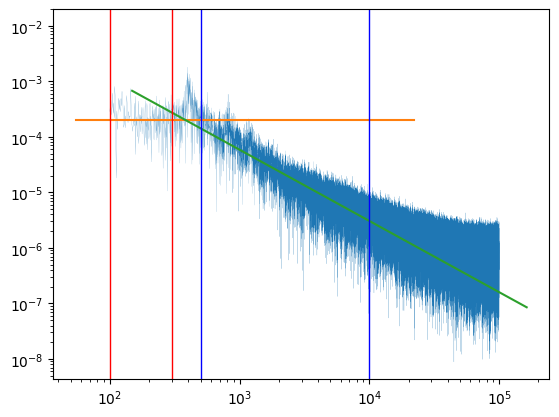

0.18250516159500954 0.16594918080500756
[-8.69492754] [[0.00108238]]
[ 0.14775864 -1.37994975] [[ 0.01045239 -0.00122544]
 [-0.00122544  0.00014432]]


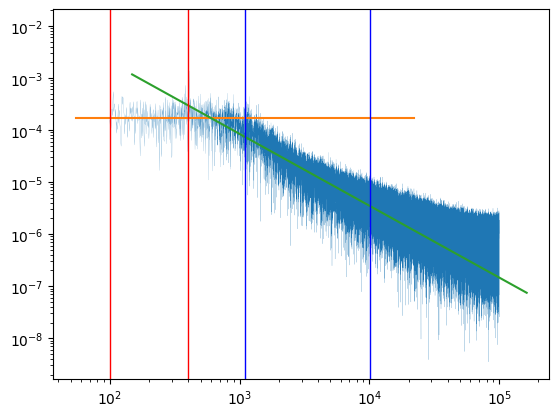

0.18397481681301128 0.1652781797100045
[-8.63980162] [[0.00160107]]
[ 0.67291291 -1.43950934] [[ 0.01066831 -0.00125075]
 [-0.00125075  0.0001473 ]]


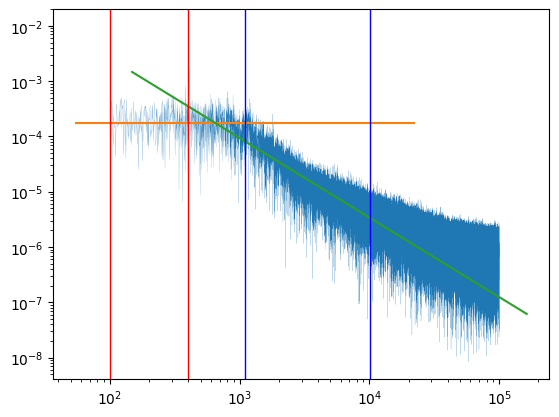

0.3285651867505393 0.34814013677500844
[-8.04889534] [[0.00109223]]
[ 2.87012373 -1.59459693] [[ 0.01142511 -0.00133603]
 [-0.00133603  0.0001569 ]]


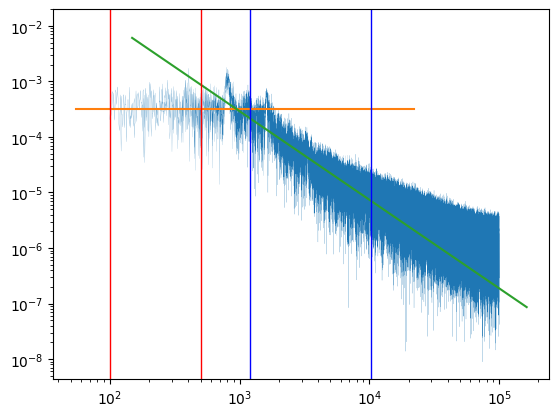

0.33075684455500104 0.3230002390299779
[-8.18814206] [[0.0009436]]
[ 1.50341814 -1.45579513] [[ 0.01113039 -0.00130157]
 [-0.00130157  0.00015285]]


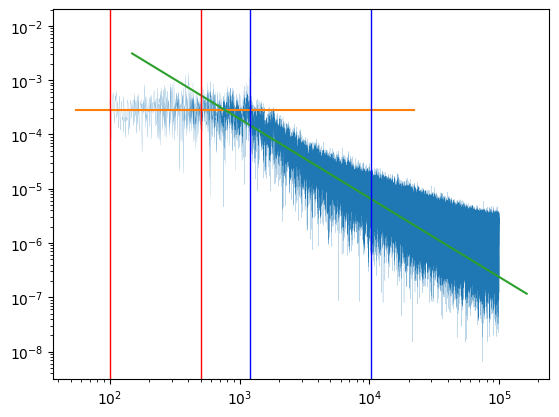

0.47977419052500325 0.5188163631200163
[-7.86008551] [[0.00099458]]
[ 1.98595541 -1.44801353] [[ 0.01176126 -0.00137191]
 [-0.00137191  0.00016067]]


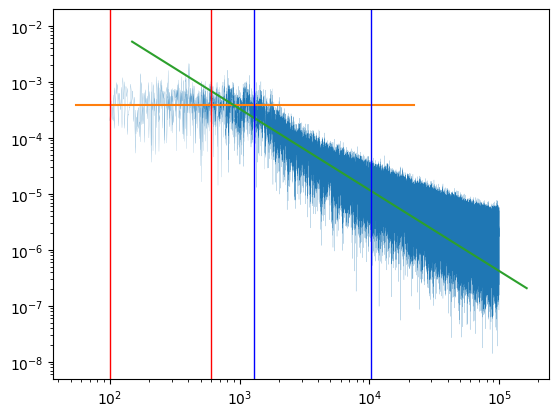

0.46343767259500035 0.515296755840005
[-7.81323043] [[0.00098132]]
[ 2.11214412 -1.46275472] [[ 0.01184259 -0.00138139]
 [-0.00138139  0.00016178]]


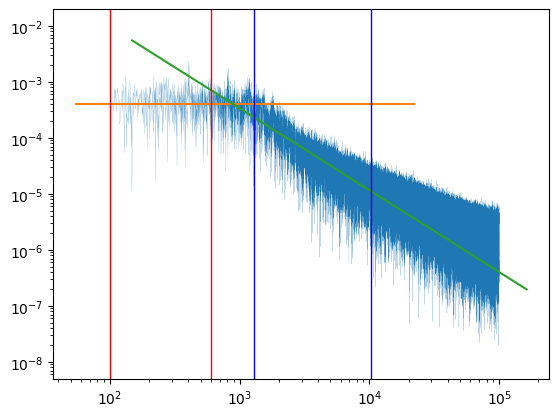

0.6076066497470983 0.5415833099449956
[-7.84535689] [[0.0007203]]
[ 1.89189218 -1.45070957] [[ 0.01295323 -0.00150728]
 [-0.00150728  0.00017606]]


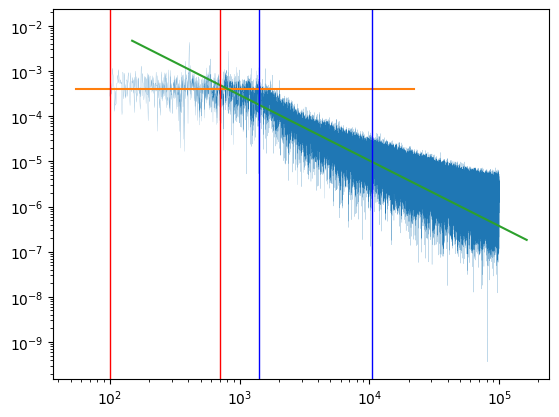

0.593918984680013 0.5906270542950246
[-7.78470343] [[0.00062204]]
[ 2.12740569 -1.45725832] [[ 0.01253273 -0.00145835]
 [-0.00145835  0.00017034]]


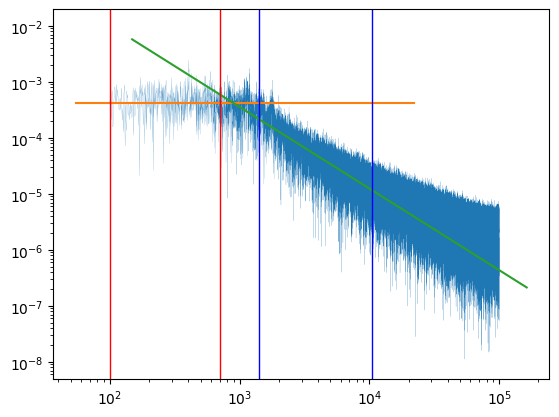

In [82]:
fits = []
for i, power_tuple in enumerate(data):
    trial_fits = []
    for trial_data in power_tuple:
        # plt.plot(trial_data[:,0], trial_data[:,1], lw=0.1)
        # plt.show()
        avgx = sum(trial_data[:,0] / len(trial_data))
        avgy = sum(trial_data[:,1] / len(trial_data))
        print(avgx, avgy)

        dists = np.sqrt((trial_data[:,0] - avgx) ** 2 + (trial_data[:,1] - avgy) ** 2)
        freqs = scipy.fft.fft(dists) / len(dists)
        plt.loglog(range(len(freqs))[100:10**5], abs(freqs[100:10**5]), lw=0.1)

        def constant_fit(x, c):
            return c 
        def neg1_slope_fit(x, c, m):
            return m*np.array(x) + c 
        constrange = [100, 3*100 + i*100]
        neg1range = [1000 + i*100  if i> 0 else 500, 1*10**4 + i*100]
        constopt, constcov = opt.curve_fit(constant_fit, np.log(range(len(freqs))[constrange[0]:constrange[1]]), np.log(freqs[constrange[0]:constrange[1]]), p0=(1))
        neg1opt, neg1cov = opt.curve_fit(neg1_slope_fit, np.log(range(len(freqs))[neg1range[0]:neg1range[1]]), np.log(freqs[neg1range[0]:neg1range[1]]), p0=(1, -1))
        print(constopt, constcov)
        print(neg1opt, neg1cov)
        plottingconst = np.linspace(4, 10, 100)
        plottingneg1 = np.linspace(5, 12, 100)
        plt.loglog(np.e ** plottingconst, np.e ** np.array([constopt[0]] * 100))
        plt.loglog(np.e ** plottingneg1, np.e ** (neg1opt[1] * plottingneg1 + np.array([neg1opt[0]] * 100)))
        plt.axline((constrange[0], 1e-8), (constrange[0], 1e-2), linewidth=1, color='r')
        plt.axline((constrange[1], 1e-8), (constrange[1], 1e-2), linewidth=1, color='r')
        plt.axline((neg1range[0], 1e-8), (neg1range[0], 1e-2), linewidth=1, color='b')
        plt.axline((neg1range[1], 1e-8), (neg1range[1], 1e-2), linewidth=1, color='b')
        plt.show()

        trial_fits += [{'c':(constopt, constcov), 'bm':(neg1opt, neg1cov)}]
    fits += [trial_fits]

In [75]:
# print(fits)
for power in fits:
    for trial in power:
        # we want f0 * m + b = c => f0 = (c-b)/m
        subtraction = (trial['c'][0] - trial['bm'][0][0])
        division = trial['bm'][0][1]
        f0beforee = subtraction / division # this is alpha/(2*pi*beta)
        f0 = np.e ** f0beforee
        # need: beta!
        # err is (sq of err before exponentiation) * (sq of derivative of exponent which is just... the exponent)
        f0err = np.sqrt((trial['c'][1] ** 2 + trial['bm'][1][0,0] ** 2) / (subtraction ** 2) + trial['bm'][1][1,1] ** 2 / (division ** 2)) * f0
        print(f0, f0err)

[387.25158056] [[0.34404437]]
[577.07544863] [[0.83070289]]
[592.7112971] [[0.84506755]]
[960.1691536] [[1.11233346]]
[773.70614534] [[0.99914949]]
[906.2401293] [[1.13905015]]
[894.07128661] [[1.1222675]]
[844.06758724] [[1.10173981]]
[912.27636304] [[1.14340082]]
